In [1]:
import datetime
import math
import os
from enum import Enum

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from patchify import patchify
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers import Rescaling
from tqdm import tqdm

import tensorflow as tf

In [2]:
len(tf.config.list_physical_devices("GPU"))>0

False

In [3]:
!nvidia-smi

Mon May  8 00:43:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.61                 Driver Version: 531.61       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 T...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0               30W /  N/A|      0MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# =======================================================
# image preprocessing

def load_images_and_patchify(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for file_number, filepath in tqdm(enumerate(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"

            # Reads image as BGR
            image = cv2.imread(img_path)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))

            # Extract patches from each image, step=patch_size means no overlap
            patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            # iterate over vertical patch axis
            for j in range(patch_img.shape[0]):
                # iterate over horizontal patch axis
                for k in range(patch_img.shape[1]):
                    # patches are located like a grid. use (j, k) indices to extract single patched image
                    single_patch_img = patch_img[j, k]

                    # Drop extra dimension from patchify
                    instances.append(np.squeeze(single_patch_img))

    return instances


def reshape_images(instances):
    """
    :param instances: list of images
    :return: reshaped images
    """
    for j in range(len(instances)):
        instances[j] = instances[j].reshape(-1, 1)
    return instances


def get_minimum_image_size(instances):
    """
    :param instances: list of images
    :return: min and max dimensions out of all images
    """

    # initialize minimum values to infinity
    min_x = math.inf
    min_y = math.inf

    # loop through each instance
    for image in instances:
        # check min x (rows)
        min_x = image.shape[0] if image.shape[0] < min_x else min_x

        # check min y (columns)
        min_y = image.shape[1] if image.shape[1] < min_y else min_y

    return min_x, min_y


def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()

In [5]:
# =====================================================
# prepare training data input images

def get_training_data(root_directory):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # define image patch size
    patch_size = 160

    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:

            # extract training input images and patchify
            if subdirectory == "images":
                image_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

            # extract training label masks and patchify
            elif subdirectory == "masks":
                mask_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset)


def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)


# mask color codes
# class MaskColorMap(Enum):
#     Unlabelled = (155, 155, 155)
#     Building = (60, 16, 152)
#     Land = (132, 41, 246)
#     Road = (110, 193, 228)
#     Vegetation = (254, 221, 58)
#     Water = (226, 169, 41)

class MaskColorMap(Enum):
    unlabeled = (0, 0, 0)
    paved_area = (128, 64, 128)
    dirt = (130, 76, 0)
    grass = (0, 102, 0)
    gravel = (112, 103, 87)
    water = (28, 42, 168)
    rocks = (48, 41, 30)
    pool = (0, 50, 89)
    vegetation = (107, 142, 35)
    roof = (70, 70, 70)
    wall = (102, 102, 156)
    window = (254, 228, 12)
    door = (254, 148, 12)
    fence = (190, 153, 153)
    fence_pole = (153, 153, 153)
    person = (255, 22, 96)
    dog = (102, 51, 0)
    car = (9, 143, 150)
    bicycle = (119, 11, 32)
    tree = (51, 51, 0)
    bald_tree = (190, 250, 190)
    ar_marker = (112, 150, 146)
    obstacle = (2, 135, 115)
    conflicting = (255, 0, 0)



def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [6]:
def get_dt_now_formatted() -> str:
    dt_now = str(datetime.datetime.now())
    dt_now = dt_now.replace("-","")
    dt_now = dt_now.replace(" ","_")
    dt_now = dt_now.replace(":","")
    dt_now = dt_now.replace(".","")
    print(dt_now)
    return dt_now

In [7]:
# =====================================================
# output directories

# datetime for filename saving
dt_now = get_dt_now_formatted()
current_dir = os.getcwd()
models_dir = "models"
logs_dir = "logs"
file_name_save = f"final_aerial_segmentation_{dt_now}"
model_img_save_path = os.path.join(current_dir, models_dir, f"{file_name_save}.png")
model_save_path = os.path.join(current_dir, models_dir, f"{file_name_save}.hdf5")
model_checkpoint_filepath = os.path.join(current_dir, models_dir, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
csv_logger = os.path.join(current_dir, logs_dir, f"aerial_segmentation_log_{dt_now}.csv")


20230507_224944570511


In [8]:
# =======================================================
# training metrics

# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

9it [00:00, 142.27it/s]
9it [00:00, 215.01it/s]
9it [00:00, 280.65it/s]
9it [00:00, 642.89it/s]
9it [00:00, 165.45it/s]
9it [00:00, 225.09it/s]
9it [00:00, 83.62it/s]
9it [00:00, 135.31it/s]
9it [00:00, 67.92it/s]
9it [00:00, 86.10it/s]
9it [00:00, 104.00it/s]
9it [00:00, 137.25it/s]
9it [00:00, 18.94it/s]
9it [00:00, 31.81it/s]
9it [00:00, 24.80it/s]
9it [00:00, 32.52it/s]


number of patched image training data: 3483


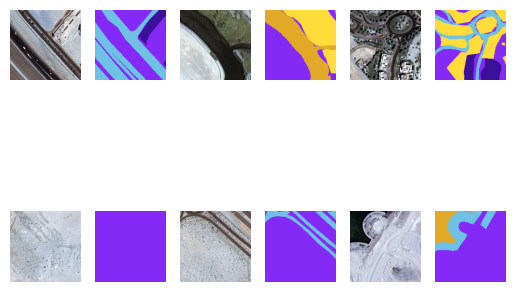

100%|██████████| 3483/3483 [00:08<00:00, 427.86it/s]


In [9]:
# =====================================================
# get training data

# number of classes in segmentation dataset
n_classes = 6

# dataset directory
data_dir = "semantic_segmentation_dataset"

# create (X, Y) training data
X, Y = get_training_data(root_directory=data_dir)

# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape
print('number of patched image training data:', m)

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=2)

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


In [10]:
# =====================================================
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = rescale  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)


# build model
model = build_unet(img_shape=(img_height, img_width, img_channels))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
# =======================================================
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True,
                             mode="max")

# stop model training early if validation loss doesn't continue to decrease over 2 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=1, mode="min")

# log training console output to csv
csv_logger = CSVLogger(csv_logger, separator=";", append=False)

# create list of callbacks
callbacks_list = [checkpoint, csv_logger]  # early_stopping

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy", iou_coefficient, jaccard_index])

# train and save model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), callbacks=callbacks_list,
          verbose=1)
model.save(model_save_path)
print("model saved:", model_save_path)


Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.1220 - accuracy: 0.5564 - iou_coefficient: 0.3526 - jaccard_index: 0.3175
Epoch 1: val_accuracy improved from -inf to 0.72043, saving model to d:\source\u-net-aerial-imagery-segmentation\models\weights-improvement-01-0.72.hdf5
98/98 [==============================] - 119s 1s/step - loss: 1.1220 - accuracy: 0.5564 - iou_coefficient: 0.3526 - jaccard_index: 0.3175 - val_loss: 0.7597 - val_accuracy: 0.7204 - val_iou_coefficient: 0.5285 - val_jaccard_index: 0.4768
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.7368 - iou_coefficient: 0.5050 - jaccard_index: 0.4632
Epoch 2: val_accuracy improved from 0.72043 to 0.76250, saving model to d:\source\u-net-aerial-imagery-segmentation\models\weights-improvement-02-0.76.hdf5
98/98 [==============================] - 131s 1s/step - loss: 0.7609 - accuracy: 0.7368 - iou_coefficient: 0.5050 - jaccard_index: 0.4632 - val_loss: 0.6923 - val_ac

In [ ]:
# =====================================================
# load pre-trained model

# model_dir = '/Users/andrewdavies/Code/tensorflow-projects/u-net-aerial-imagery-segmentation/models/'
model_dir = 'models/'
model_name = 'final_aerial_segmentation_20230507_192936400066.hdf5'

# model = load_model(
#     model_dir + model_name,
#     custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index}
# )
    

In [11]:
# =====================================================
# Predict

def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

def predict_model_just_created(use_model: Model):
    if use_model is None:
        model_dir = 'models/'
        model_name = 'final_aerial_segmentation_2022-11-09 22_37_27_640199.hdf5'
        use_model = load_model(
            model_dir + model_name,
            custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})

    for _ in range(20):
        # choose random number from 0 to test set size
        test_img_number = np.random.randint(0, len(X_test))

        # extract test input image
        test_img = X_test[test_img_number]

        # ground truth test label converted from one-hot to integer encoding
        ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

        # expand first dimension as U-Net requires (m, h, w, nc) input shape
        test_img_input = np.expand_dims(test_img, 0)

        # make prediction with model and remove extra dimension
        # prediction = np.squeeze(model.predict(test_img_input))
        prediction = np.squeeze(use_model.predict(test_img_input))

        # convert softmax probabilities to integer values
        predicted_img = np.argmax(prediction, axis=-1)

        # convert integer encoding to rgb values
        rgb_image = rgb_encode_mask(predicted_img)
        rgb_ground_truth = rgb_encode_mask(ground_truth)

        # visualize model predictions
        display_images(
            [test_img, rgb_ground_truth, rgb_image],
            rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
        )


In [40]:
def predict(dir_images, use_model : Model = None):
    if use_model is None:
        model_dir = 'models/'
        model_name = 'final_aerial_segmentation_20230507_192936400066.hdf5'
        use_model = load_model(
            model_dir + model_name,
            custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
    
    # print(use_model.summary())
    # dir_images = sorted(dir_images,)
    # predict images
    predicted_imgs = []
    for img_path in dir_images:
        print(img_path)
        img = cv2.imread(img_path)
        sample_images=[img]
        display_images(sample_images, rows=1)

        
        img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_images=[img_original]
        display_images(sample_images, rows=1)
        
        img_resized = cv2.resize(img_original, (160, 160))
        sample_images=[img_resized]
        display_images(sample_images, rows=1)

        # img = img / 255
        # sample_images=[img]
        # display_images(sample_images, rows=1)

        img = np.expand_dims(img_resized, axis=0)
        sample_images=[img]
        # display_images(sample_images, rows=1)

        # img = np.expand_dims(img, axis=3)
        img = img.astype(np.float32)
        sample_images=[img]
        # display_images(sample_images, rows=1)
        
        # make prediction with model and remove extra dimension
        # prediction = np.squeeze(model.predict(test_img_input))
        prediction = np.squeeze(use_model.predict(img))
        sample_images=[prediction]
        # display_images(sample_images, rows=1)

        predicted_imgs.append(prediction)

        # convert softmax probabilities to integer values
        predicted_img = np.argmax(prediction, axis=-1)
        print(predicted_img.shape)
        sample_images=[predicted_img]
        display_images(sample_images, rows=1)

        # convert integer encoding to rgb values
        rgb_image = rgb_encode_mask(predicted_img)
        sample_images=[rgb_image]
        display_images(sample_images, rows=1)

        # visualize model predictions
        display_images(
            [img_resized, rgb_image],
            rows=1, titles=['Aerial', 'Prediction']
        )

D:\source\20230507_TCC\dataset\20161112_sample_01\DJI_0140.JPG


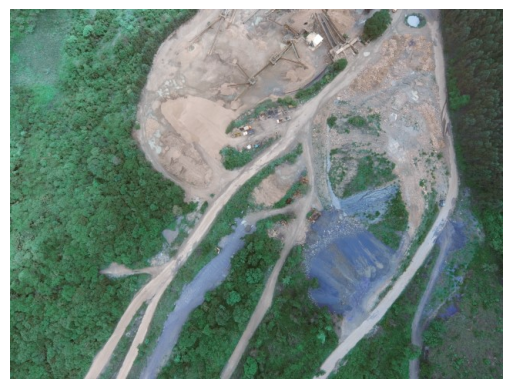

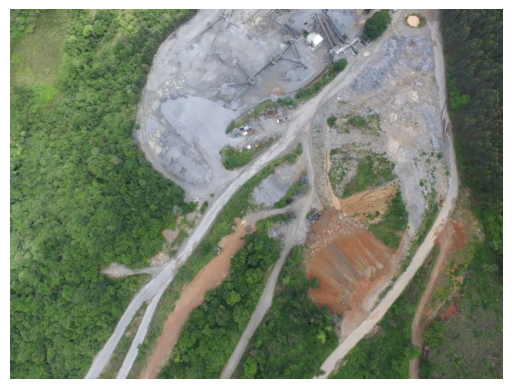

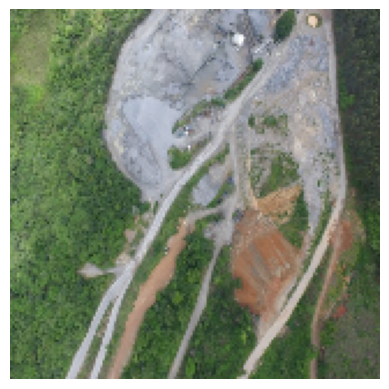

1/1 [==============================] - 0s 199ms/step
(160, 160)


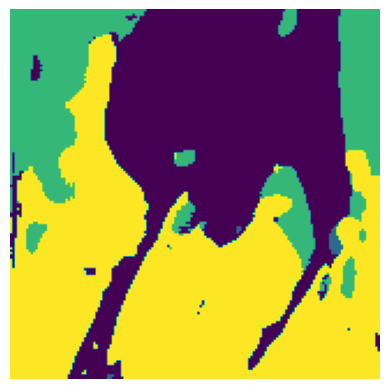

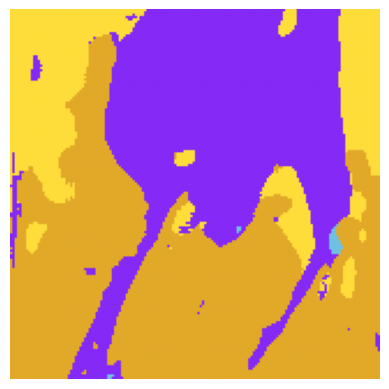

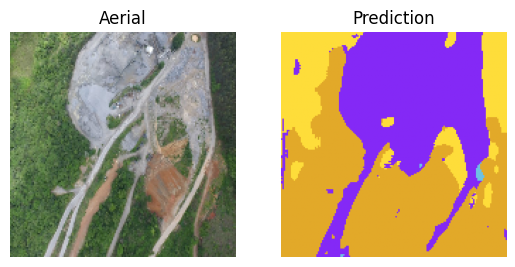

D:\source\20230507_TCC\dataset\20161112_sample_01\DJI_0140.JPG


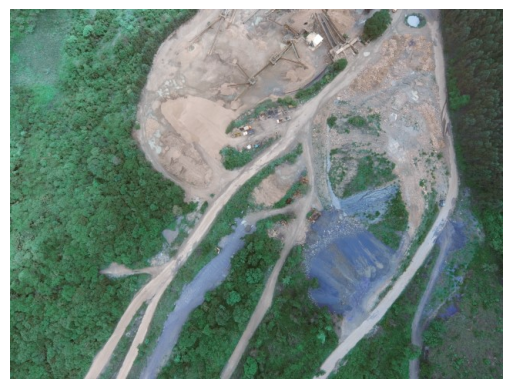

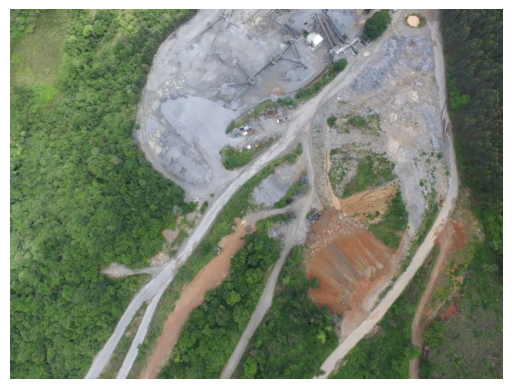

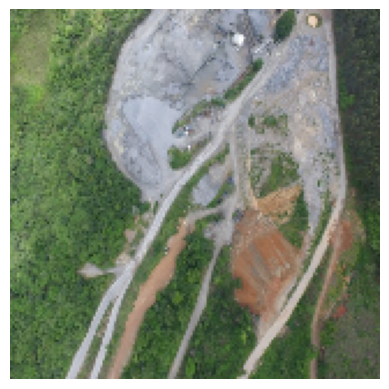

1/1 [==============================] - 0s 155ms/step
(160, 160)


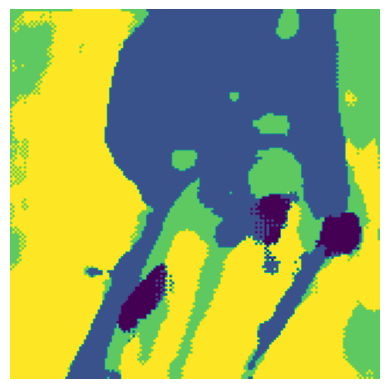

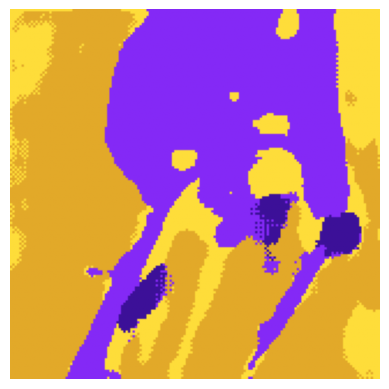

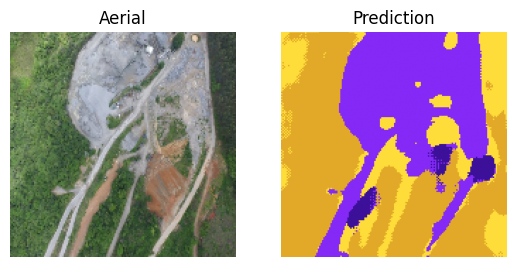

In [45]:
dir_images = [r"D:\source\20230507_TCC\dataset\20161112_sample_01\DJI_0140.JPG"]
model_dir = 'models/'
model_name = r"final_aerial_segmentation_2022-11-09 22_37_27_640199.hdf5"
use_model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
predict(dir_images, use_model)

model_name = r"final_aerial_segmentation_20230507_192936400066.hdf5"
use_model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})
predict(dir_images, use_model)